# Fetch Codebase and Models (git에서 higan프로젝트 파일 불러오기)

In [ ]:
import os
os.chdir('/content')
CODE_DIR = 'higan'
!git clone https://github.com/genforce/higan.git $CODE_DIR
os.chdir(f'./{CODE_DIR}')
!mkdir -p models/pretrain/pytorch
!wget https://www.dropbox.com/s/h1w7ld4hsvte5zf/stylegan_bedroom256_generator.pth?dl=1 -O models/pretrain/pytorch/stylegan_bedroom256_generator.pth --quiet
!wget https://www.dropbox.com/s/hwjyclj749qtp89/order_w.npy?dl=1 -O order_w_1k.npy --quiet


Cloning into 'higan'...
remote: Enumerating objects: 288, done.
remote: Counting objects: 100% (288/288), done.
remote: Compressing objects: 100% (226/226), done.
remote: Total 288 (delta 77), reused 263 (delta 58), pack-reused 0 (from 0)
Receiving objects: 100% (288/288), 16.22 MiB | 33.41 MiB/s, done.
Resolving deltas: 100% (77/77), done.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!pip install ttach

# Define Utility Functions

In [ ]:
import io
import IPython.display
import cv2
import PIL.Image
import os
import numpy as np
from tqdm import tqdm
import torch

from models.helper import build_generator
from utils.logger import setup_logger
from utils.editor import get_layerwise_manipulation_strength
from utils.editor import manipulate


def imshow(images, col, viz_size=256):
  """Shows images in one figure."""
  num, height, width, channels = images.shape
  assert num % col == 0
  row = num // col

  fused_image = np.zeros((viz_size * row, viz_size * col, channels), dtype=np.uint8)

  for idx, image in enumerate(images):
    i, j = divmod(idx, col)
    y = i * viz_size
    x = j * viz_size
    if height != viz_size or width != viz_size:
      image = cv2.resize(image, (viz_size, viz_size))
    fused_image[y:y + viz_size, x:x + viz_size] = image

  fused_image = np.asarray(fused_image, dtype=np.uint8)
  data = io.BytesIO()
  PIL.Image.fromarray(fused_image).save(data, 'jpeg')
  im_data = data.getvalue()
  disp = IPython.display.display(IPython.display.Image(im_data))
  return disp

def build_model(model_name, logger=None):
  """Builds the generator by model name."""
  model = build_generator(model_name, logger=logger)
  return model

# latent_code를 반환해주는 함수
def sample_codes(model, num, seed=0, w1k_code=None):
  """Samples latent codes randomly."""
  np.random.seed(seed)
  if w1k_code is None:
    codes = generator.easy_sample(num)
    latent_codes = model.easy_sample(num=num, latent_space_type='w')
  else:
    latent_codes = w1k_code[np.random.randint(0, w1k_code.shape[0], num)]
  latent_codes = model.easy_synthesize(latent_codes=latent_codes,
                                       latent_space_type='w',
                                       generate_style=False,
                                       generate_image=False)['wp']
  return latent_codes

w1k_code = np.load('order_w_1k.npy')

# Build Generator

In [ ]:
indoor_model_name = "stylegan_bedroom"
indoor_model = build_model(indoor_model_name)

/content/higan/models/base_generator.py:132: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(self.weight_path)


# 파라미터값 설명
 - (num sample, noise seed, image num)
 - num_sample : 생성 샘플 수
 - noise_seed : 노이즈 입력 파라미터 (고정값), 이후 동일한 이미지 생성 위해
 - image_num : 이미지 번호

# Sample Codes (Latent_code값 통해 이미지 생성)

34,63,99,149,156,160,206,286,298,376,461,517,675,

In [ ]:
#@title { display-mode: "form", run: "auto" }
num_samples = 10 #@param {type:"slider", min:1, max:100, step:1}
noise_seed = 616 #@param {type:"slider", min:0, max:1000, step:1}
image_num = 1

indoor_latent_codes = sample_codes(indoor_model, num_samples, noise_seed, w1k_code=w1k_code)
synthesis_kwargs = {'latent_space_type': 'wp'}
images = indoor_model.easy_synthesize(indoor_latent_codes, **synthesis_kwargs)['image']

# 조명 distance 낮은(없는) 이미지

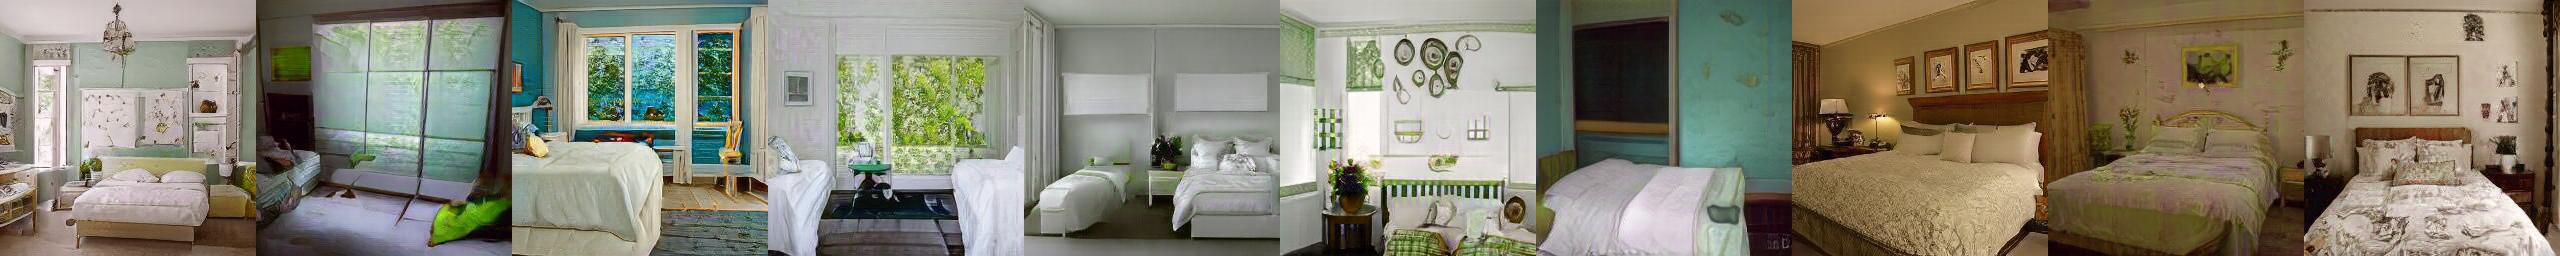

In [ ]:
#@title { display-mode: "form", run: "auto" }

attribute_name = 'indoor_lighting' #@param ['indoor_lighting', 'wood', 'cluttered_space', 'view']
path = f'boundaries/{indoor_model_name}/{attribute_name}_boundary.npy'
#print(f'Loading boundary from {path}')
try:
  boundary_file = np.load(path, allow_pickle=True).item()
  boundary = boundary_file['boundary']
  manipulate_layers = boundary_file['meta_data']['manipulate_layers']
except ValueError:
  boundary = np.load(path)
  if attribute_name == 'view':
    manipulate_layers = '0-4'
  else:
    manipulate_layers = '6-11'


if attribute_name == 'view':
  strength = [1.0 for _ in range(indoor_model.num_layers)]
else:
  strength = get_layerwise_manipulation_strength(
    indoor_model.num_layers, indoor_model.truncation_psi, indoor_model.truncation_layers)

distance = -3 #@param {type:"slider", min:-3.0, max:3.0, step:0.1}
indoor_codes = manipulate(latent_codes=indoor_latent_codes,
                     boundary=boundary,
                     start_distance=0,
                     end_distance=distance,
                     step=2,
                     layerwise_manipulation=True,
                     num_layers=indoor_model.num_layers,
                     manipulate_layers=manipulate_layers,
                     is_code_layerwise=True,
                     is_boundary_layerwise=False,
                     layerwise_manipulation_strength=strength)
images = indoor_model.easy_synthesize(indoor_codes[:, 1], latent_space_type='wp')['image']
imshow(images, col=num_samples)

In [ ]:
# 생성된 이미지 저장
np.save('generated_images.npy', images)  # 이미지 저장
np.save('latent_codes_1.npy', indoor_codes)  # latent space 저장

# 선택된 번호(image_num)의 이미지

array([[[156, 161, 150],
        [155, 157, 152],
        [156, 158, 153],
        ...,
        [142, 142, 139],
        [145, 143, 140],
        [142, 141, 136]],

       [[149, 153, 145],
        [155, 159, 150],
        [153, 156, 148],
        ...,
        [139, 141, 135],
        [141, 142, 136],
        [141, 142, 135]],

       [[145, 149, 140],
        [150, 154, 145],
        [150, 154, 144],
        ...,
        [139, 141, 135],
        [141, 141, 136],
        [140, 140, 135]],

       ...,

       [[156, 158, 157],
        [156, 157, 159],
        [157, 157, 160],
        ...,
        [ 84,  84,  71],
        [ 84,  84,  71],
        [ 83,  83,  73]],

       [[156, 157, 157],
        [156, 157, 158],
        [157, 157, 159],
        ...,
        [ 85,  85,  72],
        [ 87,  87,  75],
        [ 88,  85,  77]],

       [[157, 159, 159],
        [157, 158, 160],
        [155, 157, 160],
        ...,
        [ 83,  85,  72],
        [ 87,  88,  77],
        [ 89,  86,  76]]], dtype=uint8)
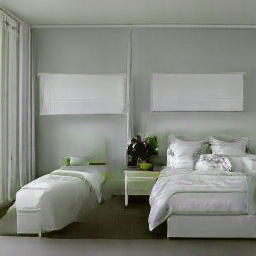

In [ ]:
image_num = 4
save_image = images
save_image[image_num]

#조명 distance 높은 이미지

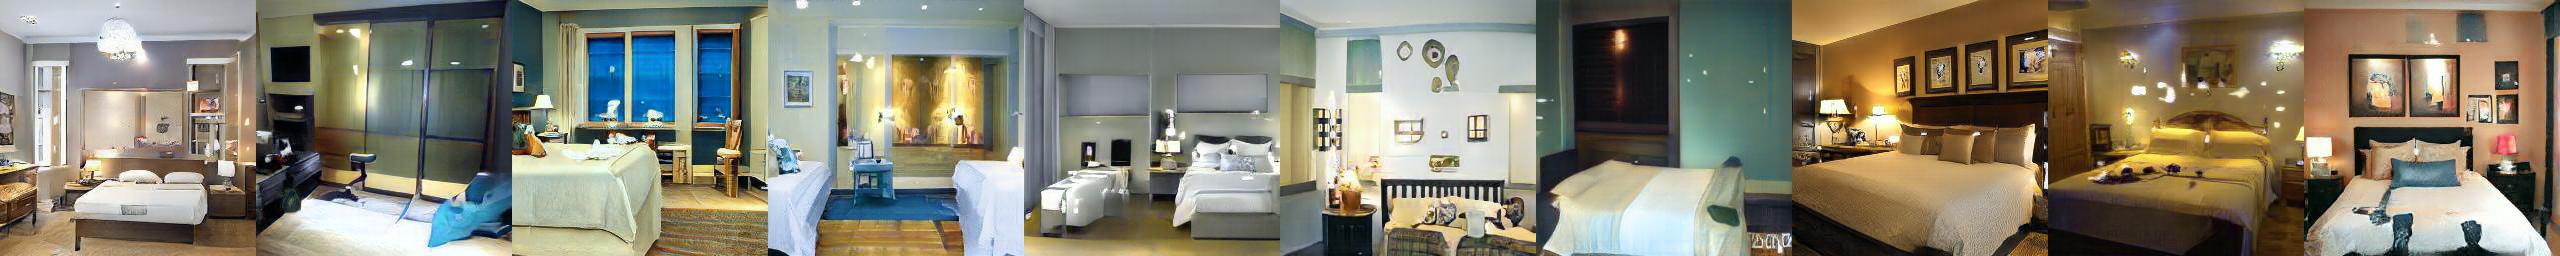

In [ ]:
distance = 3 #@param {type:"slider", min:-3.0, max:3.0, step:0.1}
indoor_codes2 = manipulate(latent_codes=indoor_latent_codes,
                     boundary=boundary,
                     start_distance=0,
                     end_distance=distance,
                     step=2,
                     layerwise_manipulation=True,
                     num_layers=indoor_model.num_layers,
                     manipulate_layers=manipulate_layers,
                     is_code_layerwise=True,
                     is_boundary_layerwise=False,
                     layerwise_manipulation_strength=strength)
images = indoor_model.easy_synthesize(indoor_codes2[:, 1], latent_space_type='wp')['image']
imshow(images, col=num_samples)

In [ ]:
# 생성된 이미지 저장
np.save('generated_images_2.npy', images)  # 이미지 저장
np.save('latent_codes_2.npy', indoor_codes2)  # latent space 저장

# 저장

In [ ]:
from PIL import Image
import numpy as np

# File name generation
output_filename = f"{num_samples}_{noise_seed}_{image_num}.png"

# PIL Image conversion
image = Image.fromarray(save_image[image_num])

# Define the target folder in Google Drive
target_folder = '/content/image'

# Save the image in the "higan" folder
image.save(target_folder + output_filename)

print(f"Image saved as {target_folder + output_filename}")


Image saved as /content/image10_616_4.png


# 이미지 저장
 - {num_sample}_{noise_seed}_{image_num}.png 형식으로